# Linear regression
In this notebook, we do regression for the problem of predicting mean activity based on non-wearable features taken from the UK biobank. We use the L1 and L2 norms, hence we use elastic-net.

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

In [2]:
from accel.constants import DATA_DIR
from accel.read_data import prep_data

## Data prep

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test, means_modes = prep_data(DATA_DIR / "shared/eliminated-missing-participants.csv",
                                                                        normalise = True,
                                                                        one_hot = True)

In [5]:
X_train.shape

(60829, 443)

## Model

In [6]:
from sklearn.linear_model import ElasticNet, LinearRegression 
from sklearn.metrics import r2_score, mean_squared_error

Since we only have two parameters to search through, we can do a random-search for a number of iterations and then plot the results in 2D. The objective function is:
$$
        1 / (2 \cdot n_\text{samples}) \cdot ||y - Xw||^2_2 \\
        + \text{alpha} * \text{l1_ratio} \cdot ||w||_1  \\
        + 0.5 * \text{alpha} * (1 - \text{l1_ratio}) \cdot ||w||^2_2
$$
When the l1_ratio is close to 1, we have mainly l1 regularisation.

In [7]:
np.random.seed(42) # set seed

In [8]:
alphas = []
l1_ratios = []
r2_scores = []
mse_scores = []
its = 50

In [9]:
for i in range(its):
    alpha = np.random.exponential(0.1) # random exponentially distributed number
    l1_ratio = np.random.uniform(0, 1) # random uniform number between 0 and 1
    print(i,np.round(alpha,4),np.round(l1_ratio,4), end=", ")
    alphas.append(alpha)
    l1_ratios.append(l1_ratio)
    # train model on training and then assess on validation
    clf = ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    r2_scores.append(r2_score(y_pred, y_val))
    mse_scores.append(mean_squared_error(y_pred, y_val))

0 0.0469 0.9507, 1 0.1513 0.5969, 2 0.017 0.0581, 3 0.0406 0.1429, 4 0.0021 0.9699, 5 0.279 0.0008, 6 0.0203 0.3042, 7 0.0007 0.0231, 

/cdthome/pkd542/.conda/envs/accel/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.053e+06, tolerance: 5.274e+02
  model = cd_fast.enet_coordinate_descent(


8 0.0946 0.1395, 9 0.364 0.2328, 10 0.1538 0.1997, 11 0.4088 0.4668, 12 0.0935 0.1705, 13 0.0013 0.9422, 

/cdthome/pkd542/.conda/envs/accel/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.229e+03, tolerance: 5.274e+02
  model = cd_fast.enet_coordinate_descent(


14 0.1652 0.3046, 15 0.0263 0.241, 16 0.013 0.4952, 17 0.019 0.3911, 18 0.1086 0.3117, 19 0.0233 0.5677, 20 0.3493 0.7751, 21 0.0503 0.9267, 22 0.2549 0.0885, 23 0.0736 0.9612, 24 0.0492 0.2713, 25 0.0884 0.9653, 26 0.0782 0.1409, 27 0.0181 0.0156, 28 0.1479 0.1987, 29 0.0014 0.1988, 30 0.1306 0.7713, 31 0.2608 0.6511, 32 0.1989 0.6233, 33 0.01 0.3708, 34 0.0393 0.7296, 35 0.0321 0.5612, 36 0.0127 0.7132, 37 0.1279 0.236, 38 0.0681 0.5227, 39 0.0118 0.4393, 40 0.0032 0.6364, 41 0.0828 0.6955, 42 0.0287 0.4104, 43 0.0227 0.9429, 44 0.0342 0.1612, 45 0.0979 0.2956, 46 0.2052 0.8037, 47 0.0539 0.8833, 48 0.1647 0.8961, 49 0.2373 0.2721, 

##  Visualise output

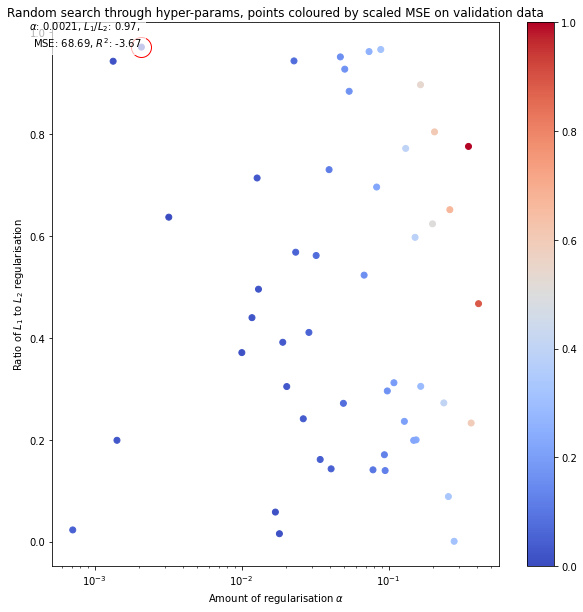

In [12]:
mse = np.array(mse_scores)
r2 = np.array(r2_scores)
scaled_mse = (mse - np.min(mse)) / (np.max(mse) - np.min(mse))
arg_min = np.argmin(scaled_mse)

plt.figure(figsize=(10,10))
plt.scatter(alphas, l1_ratios, c=scaled_mse, cmap="coolwarm")
plt.xlabel("Amount of regularisation $ \\alpha $")
plt.ylabel("Ratio of $L_1$ to $L_2$ regularisation")
plt.xscale("log")
plt.title("Random search through hyper-params, points coloured by scaled MSE on validation data")
plt.colorbar()

# highlight hyper-params with min MSE
a, l1 = alphas[arg_min], l1_ratios[arg_min]
t = plt.text(a,l1,
             f"$\\alpha$: {np.round(a,4)}, $L_1/L_2$: {np.round(l1,2)}, \nMSE: {np.round(mse[arg_min],2)}, $R^2$: {np.round(r2[arg_min],2)}",
            ha = "right")
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))
plt.plot(a,l1,"ro",mfc='none',markersize=20)

plt.show()


Assess model performance

In [13]:
from accel.training import score

In [16]:
clf = ElasticNet(alpha=alphas[arg_min], l1_ratio=l1_ratios[arg_min]).fit(X_train, y_train)
_ = score(clf.predict(X_test),y_test)

MSE is:  71.51077533135975
R2 is:  -3.7400438653702324
Explained variance is: -3.7397438235373706


Since a model with relative low amounts of regularisaiton performs best, how does this compare to just vanilla linear regression?

In [17]:
clf = LinearRegression().fit(X_train, y_train)
_ = score(clf.predict(X_test),y_test)

MSE is:  71.89625516679777
R2 is:  -3.5777022059887846
Explained variance is: -3.5773643285859995
